data source is :http://www.sciamachy-validation.org/climatology/daily_data/selection.cgi

from where we select Leeuwarden and clean up a bit the
header by removing the comments 
and renaming the column headers to

STN,Date,Mean,Min,Max

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import statsmodels.api as sm  


In [118]:
weather = pd.read_csv('leeuwarden-temp.csv')


In [3]:
print (weather.head())
print ('\n Data Types:')
print (weather.dtypes)

   STN      Date   Mean    Min    Max
0  270  19510101      0    -40     24
1  270  19510102      9     -5     19
2  270  19510103      5     -8     17
3  270  19510104      5    -15     17
4  270  19510105     26      6     46

 Data Types:
STN      int64
Date     int64
Mean    object
Min     object
Max     object
dtype: object


# Let's parse the data as an actual time series

In [166]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
weather = pd.read_csv('leeuwarden-temp.csv', parse_dates=True, index_col='Date',date_parser=dateparse)
print (weather.head())

            STN   Mean    Min    Max
Date                                
1951-01-01  270      0    -40     24
1951-01-02  270      9     -5     19
1951-01-03  270      5     -8     17
1951-01-04  270      5    -15     17
1951-01-05  270     26      6     46


# If we try to do anything with our data, e.g. plot it, we'll encounter problems since our data is not numerical. Let's convert it to numerical. 

in our case, there seems to be a missing value since we get an uable to parse stirng "   ". what we can do is to coerce the value to a NaN. 

on top of that, these NaN's must be replaced with valid values. we use a method called 'pad' which fills backwards the missing data.


In [240]:
weather['Max']=pd.to_numeric(weather['Max'], errors="coerce")
weather.Max=weather.Max.fillna(method='pad')

# Our data is actually in 0.1 degrees Celsius, so we can convert it to degress

In [175]:
weather['Max Degrees']=weather['Max'] / 10

# Let's visualize our data

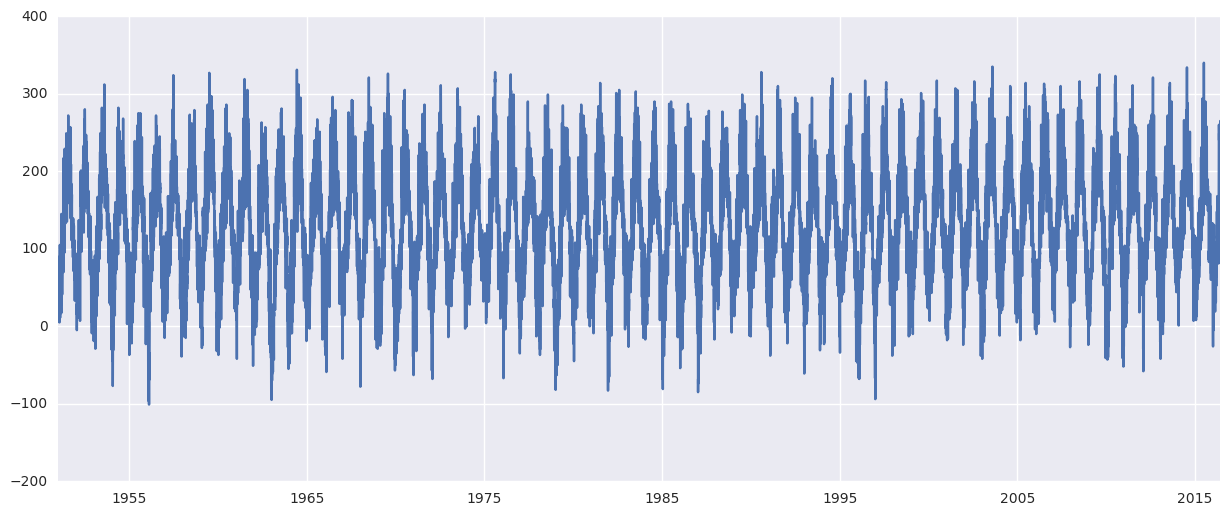

In [185]:
axes = plt.gca()
plt.plot(weather['Max'])

# Converting the data into a series object

now let's create a timeseries of only the max temperature

In [190]:
temps = weather['Max Degrees']

# Let's look at the temperatures for the date of tomorrow in the past!

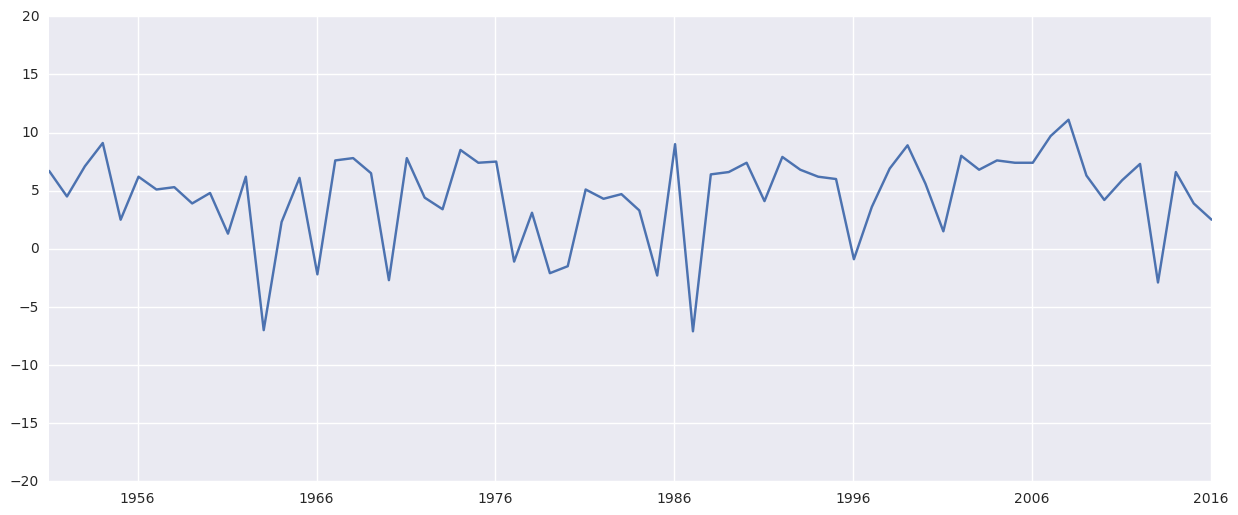

In [315]:
selector = (temps.index.day == 19) & (temps.index.month==1)
todays=temps[selector]
axes = plt.gca()
axes.set_ylim([-20,20])
plt.plot(todays)

In [235]:
rolmean = pd.Series.rolling(todays, window=5).mean()
simplemean = pd.Series.rolling(todays, window=len(todays)-1).mean()

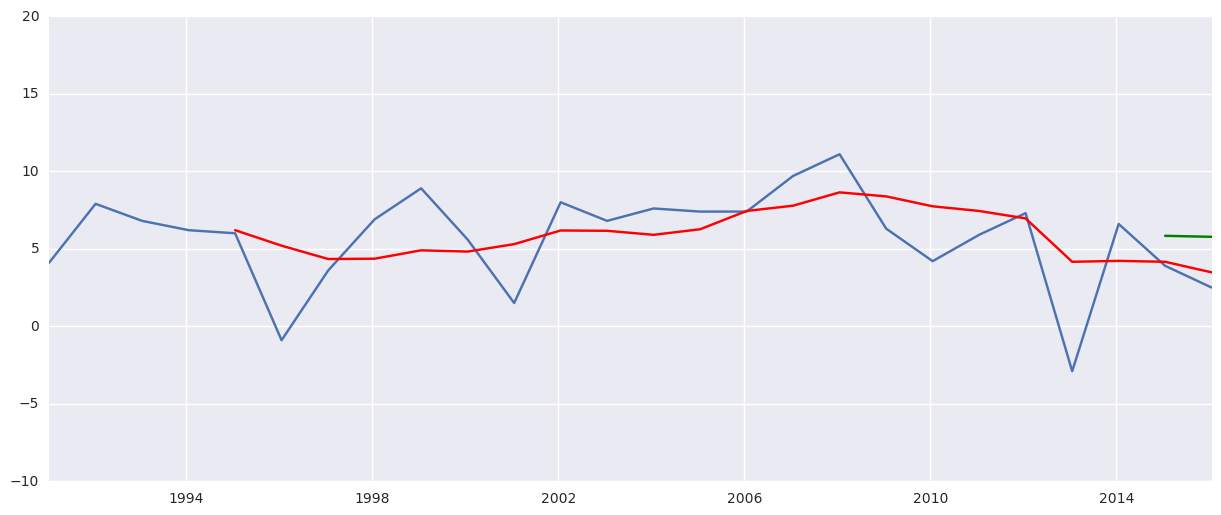

In [236]:
axes = plt.gca()
axes.set_ylim([-10,20])
plt.plot(todays)
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(simplemean, color='green', label='Mean')

# What if we look at the first of each month?

In [15]:
len(temps)

23900

In [16]:
first_of_each_month = (temps.index.day == 1)
first_days_of_month=temps[first_of_each_month]
len(first_days_of_month)

786

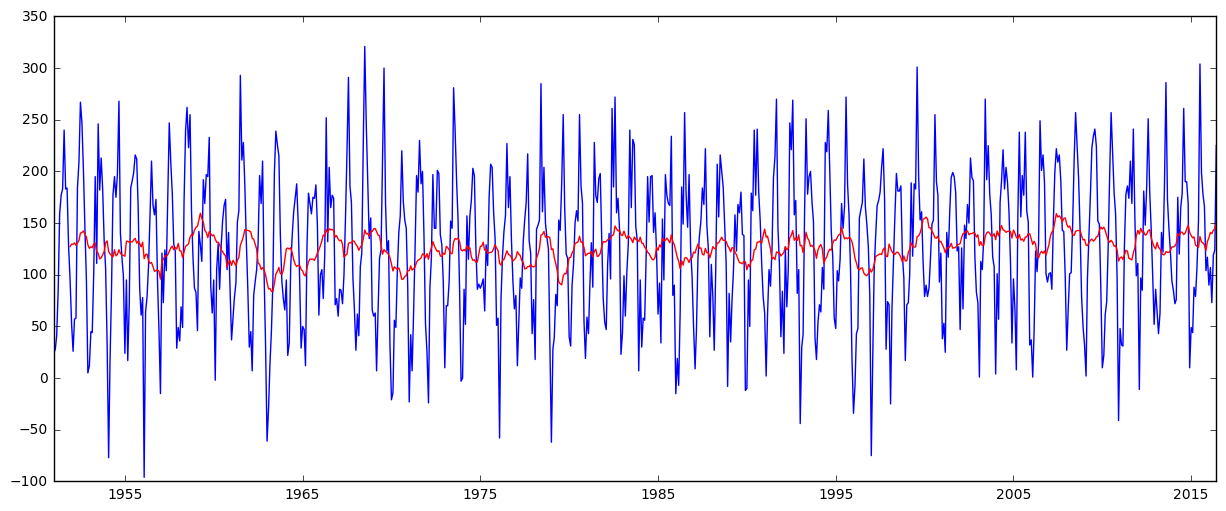

In [19]:
rolmean = pd.Series.rolling(first_days_of_month, window=12).mean()

plt.plot(first_days_of_month)
mean = plt.plot(rolmean, color='red', label='Rolling Mean')


### Trying to find autocorrelation

In [259]:
weather["Max 1-Shifted"] = weather.Max.shift(365)

# let's see the shift

In [251]:
weather[:10]

,STN,Mean,Min,Max,Max Degrees,Max 1-Shifted
Date,,,,,,
1951-01-01,270,0,-40,24.0,2.4,NaN
1951-01-02,270,9,-5,19.0,1.9,NaN
1951-01-03,270,5,-8,17.0,1.7,NaN
1951-01-04,270,5,-15,17.0,1.7,NaN
1951-01-05,270,26,6,46.0,4.6,NaN
1951-01-06,270,34,-1,68.0,6.8,NaN
1951-01-07,270,51,27,71.0,7.1,NaN
1951-01-08,270,49,15,67.0,6.7,NaN
1951-01-09,270,40,1,57.0,5.7,NaN


# let's load seaborn, and visualize the correlation between the vars

In [255]:
import seaborn as sb  
sb.set_style('darkgrid')

/Users/mircea/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


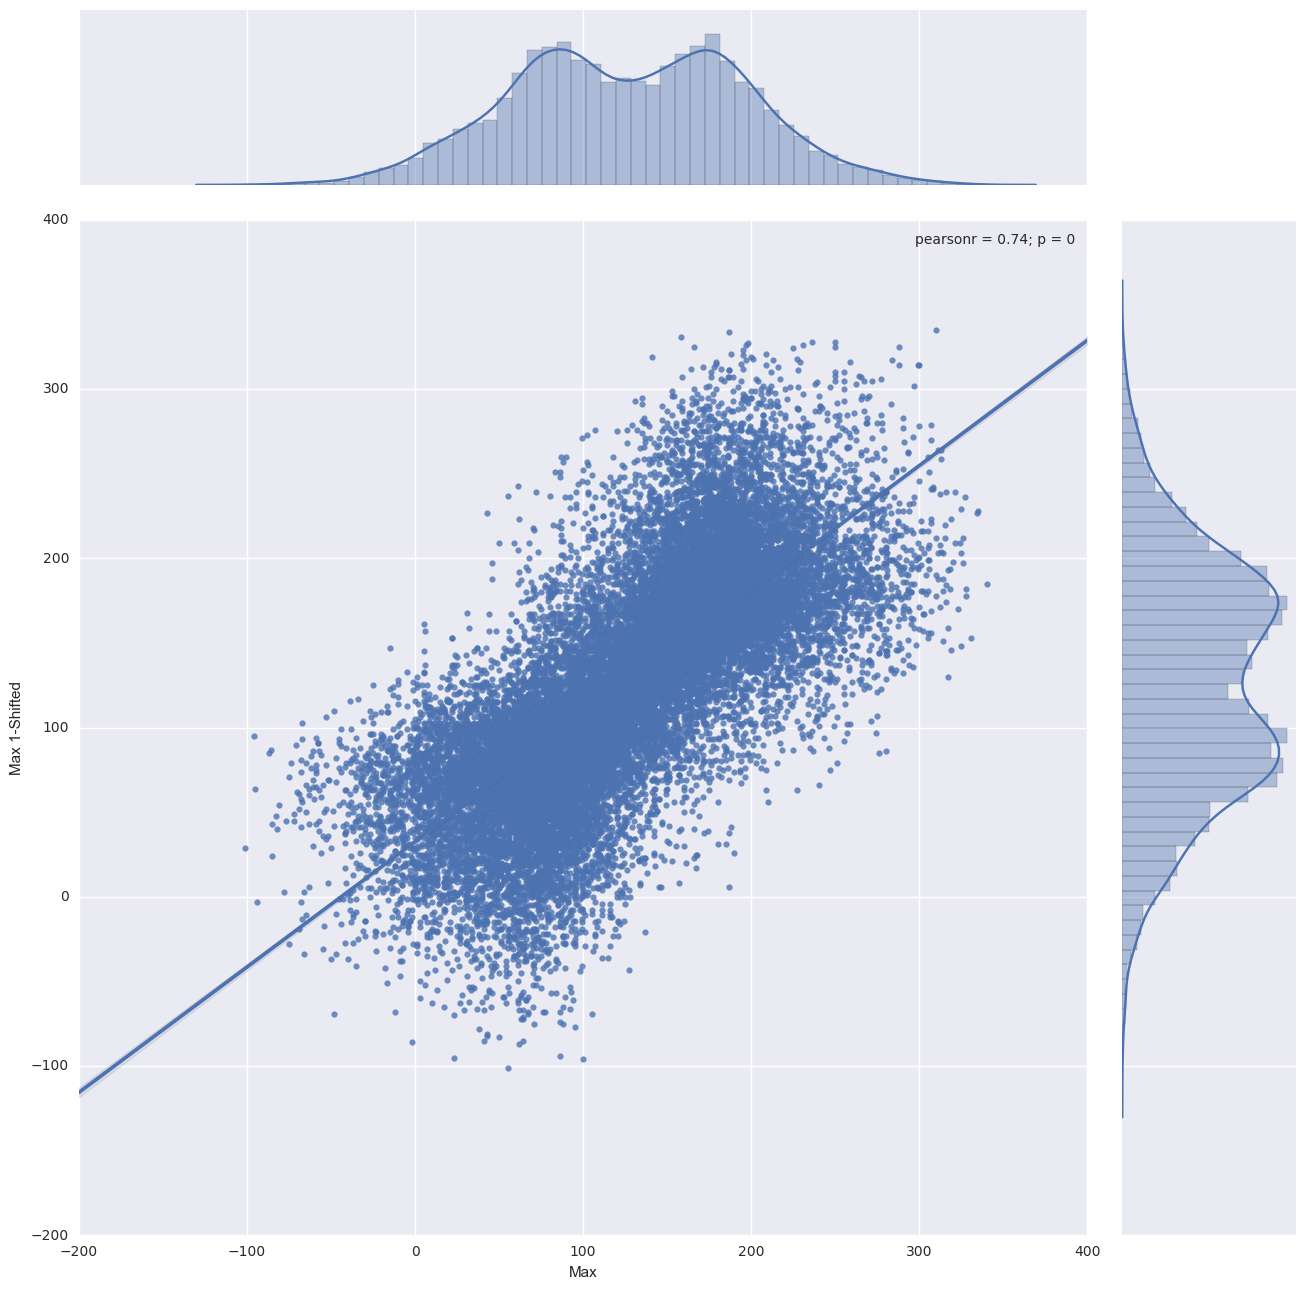

In [260]:
sb.jointplot('Max', 'Max 1-Shifted', weather, kind='reg', size=13)  

In [272]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(weather['Max'][1:])  
lag_partial_correlations = pacf(weather['Max'][1:])  


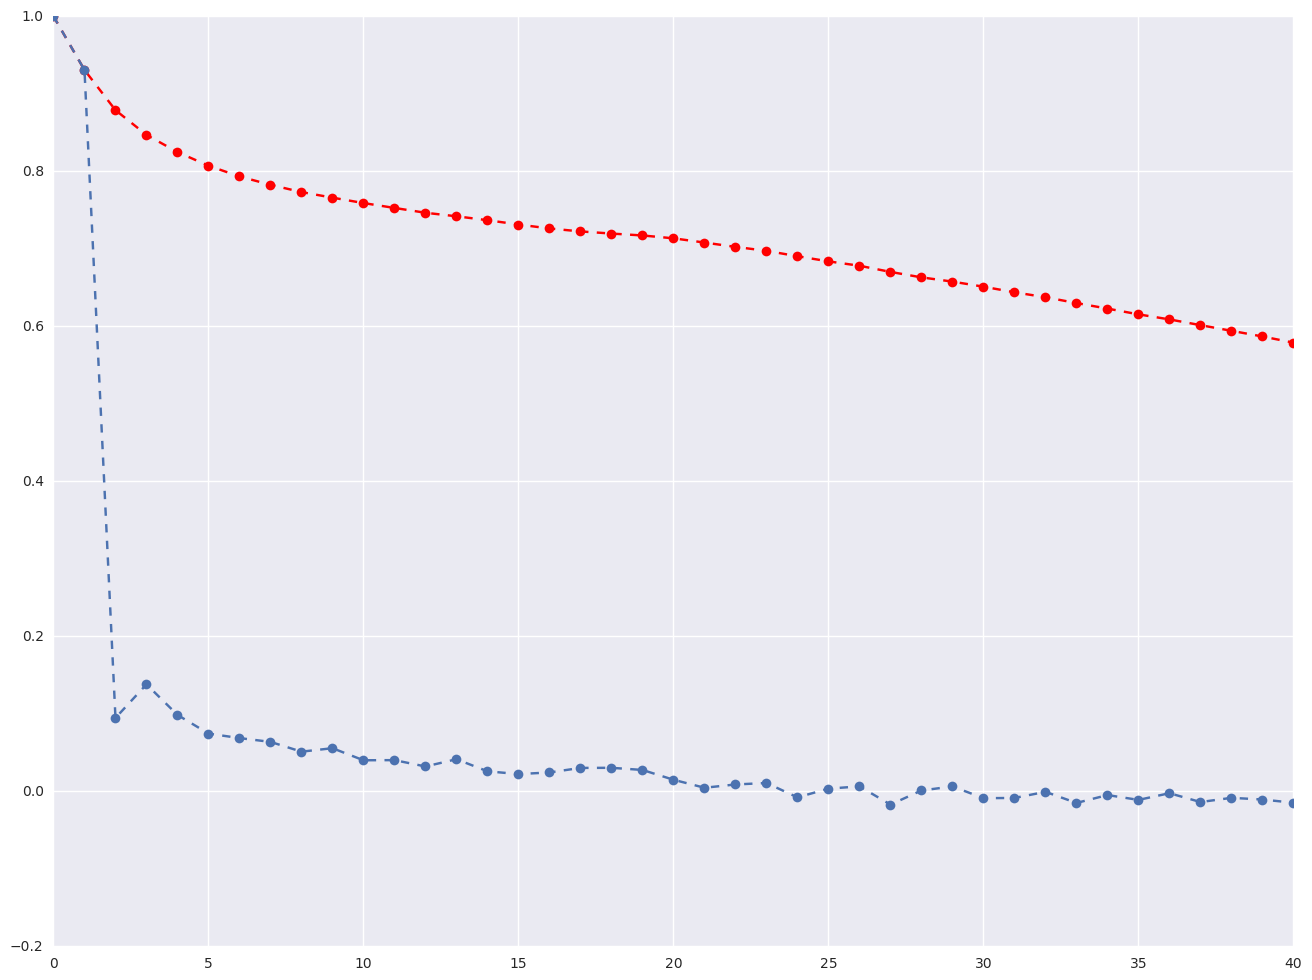

In [273]:
fig, ax = plt.subplots(figsize=(16,12))  
ax.plot(lag_correlations, marker='o', linestyle='--',color='red')  
ax.plot(lag_partial_correlations, marker='o', linestyle='--')  


# or we can use the special plot that we have for the ACF and PACF functions

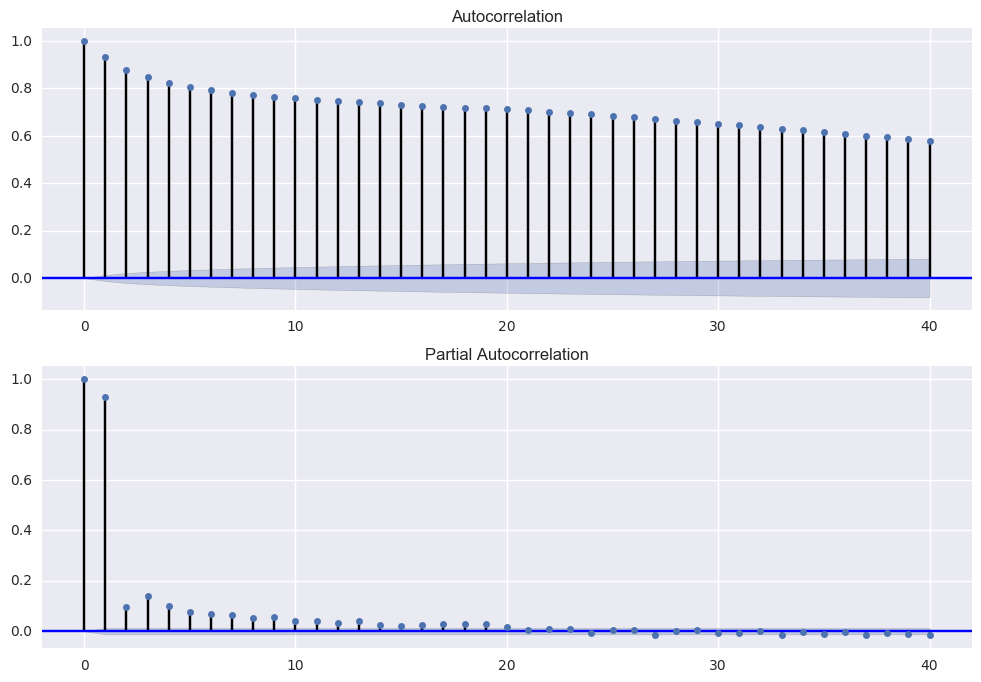

In [267]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weather['Max'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weather['Max'], lags=40, ax=ax2)


# Another interesting technique we can try is a decomposition. This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodels comes with a decompose function out of the box.



/Users/mircea/anaconda/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


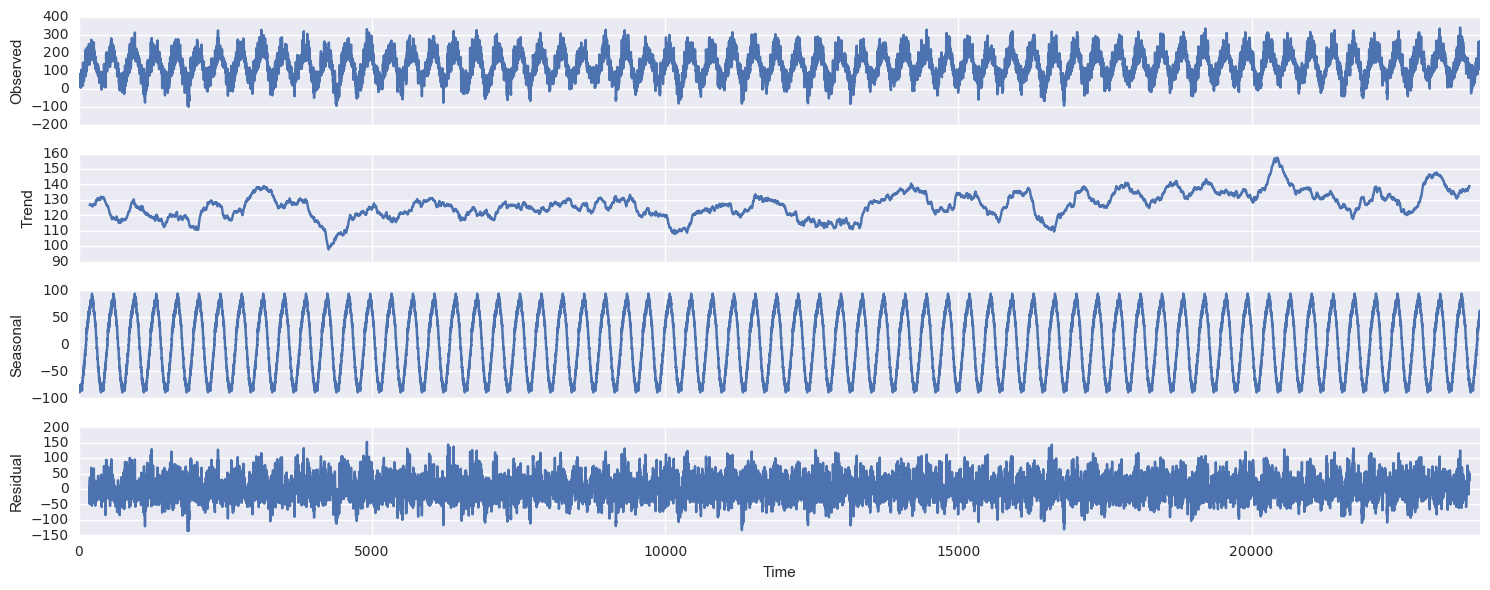

In [276]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(weather['Max'].values, model='additive', freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  


# ouch: missing data in temperature. let's fill it! the "pad" method carries forward values into the NaN.

(http://pandas.pydata.org/pandas-docs/stable/missing_data.html)

In [85]:
weather.Max=weather.Max.fillna(method='pad')

In [99]:
weather.index.inferred_freq 

'D'

/Users/mircea/anaconda/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


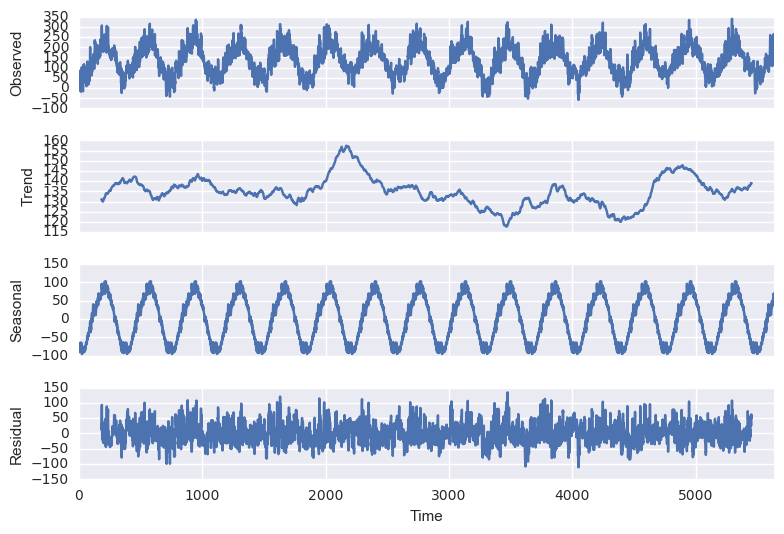

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose

selector = (temps.index.year > 2000)
recent_weather = weather[selector]
# freq need to be the # of samples in a season
decomposition = seasonal_decompose(recent_weather['Max'].values,freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  


/Users/mircea/anaconda/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


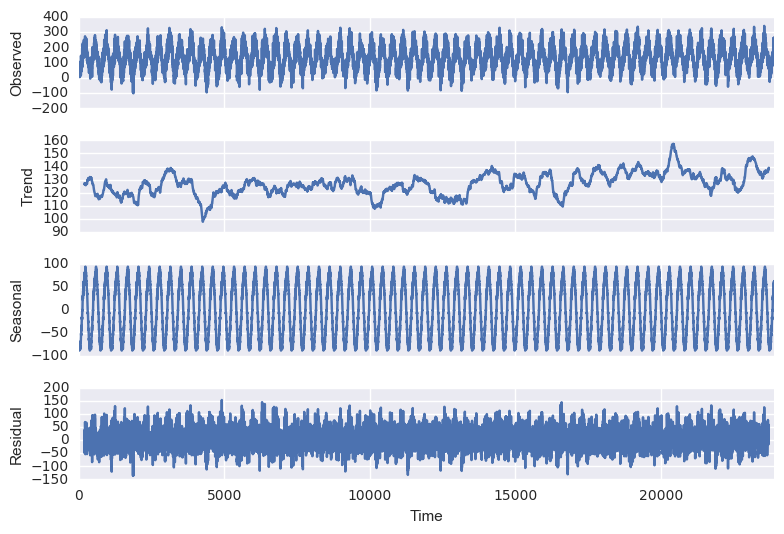

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(weather['Max'].values,freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  


# Let us fit an AR model on our data

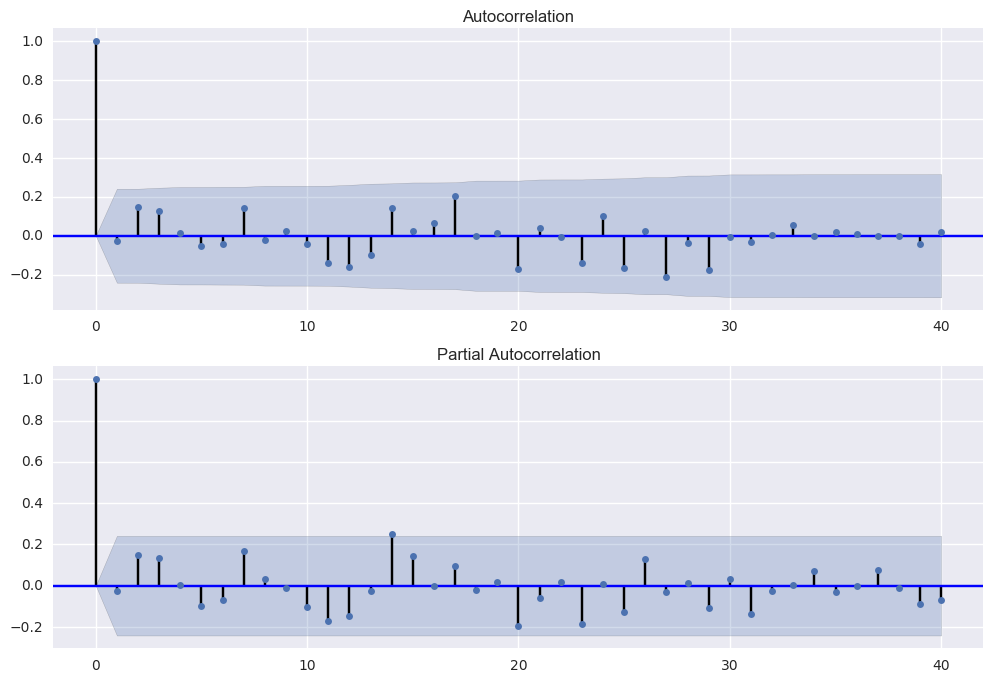

In [316]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(todays.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(todays, lags=40, ax=ax2)


In [310]:
model = sm.tsa.ARIMA(first_days_of_month, (3,1,0)).fit()
predict_mod1 = ar_mod1.predict('2016-06-01', '2016-10-01', dynamic=True)

print (ar_mod1.params)


const          0.269016
ar.L1.D.Max   -0.111412
ar.L2.D.Max    0.171957
dtype: float64


In [313]:
predict_mod1

/Users/mircea/anaconda/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


2016-06-01    7.605700
2016-07-01    0.265149
2016-08-01    1.531042
2016-09-01    0.127746
2016-10-01    0.501769
Freq: MS, dtype: float64

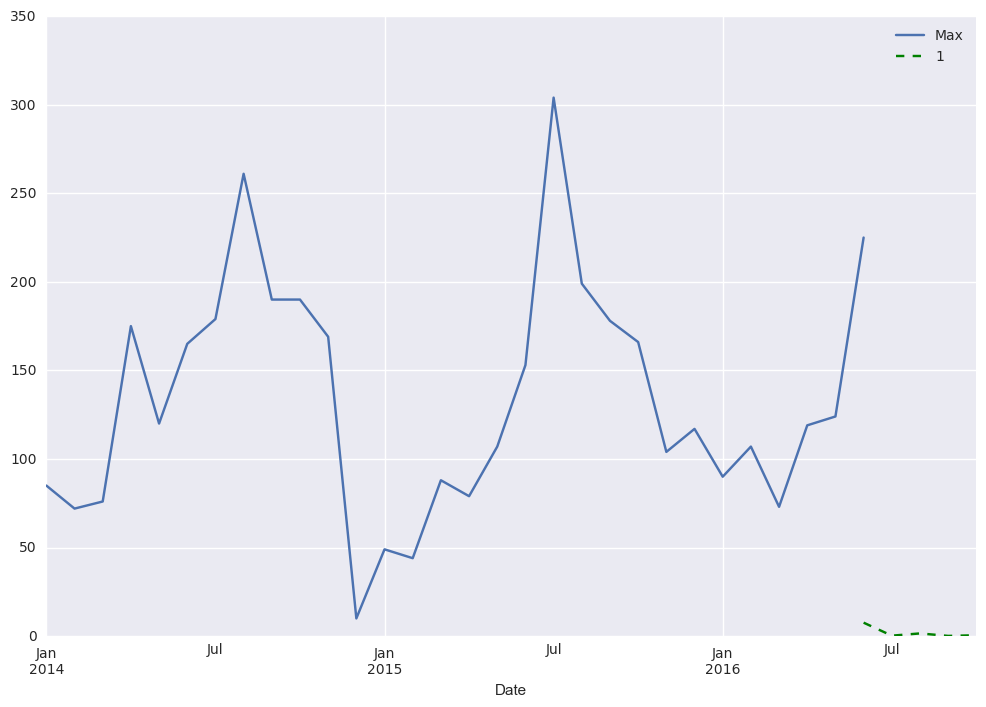

In [312]:
ax = first_days_of_month.ix['2014':].plot(figsize=(12,8))
ax = predict_mod1.plot(ax=ax, style='g--', label='1');

ax.legend();
# ax.axis((-20.0, 38.0, -4.0, 200.0));